# MLP and CNN with CIFAR10

In [24]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [25]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using Pytorch version:', torch.__version__, 'Device:',DEVICE)

Using Pytorch version: 1.10.2 Device: cuda


In [26]:
BATCH_SIZE = 32
EPOCHS = 10

In [27]:
train_dataset = datasets.CIFAR10(root="/data/CIFAR_10",
                                train=True,
                                download=True,
                                transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root="/data/CIFAR_10",
                               train=False,
                               transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = BATCH_SIZE,
                                         shuffle = False)

Files already downloaded and verified


In [28]:
for (X_train, y_train) in train_loader:
    print('X_train:',X_train.size(), 'type:', X_train.type())
    print('y_train:',y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


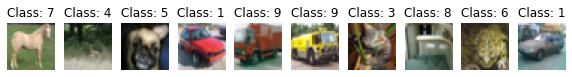

In [29]:
pltsize = 1
plt.figure(figsize=(10*pltsize,pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i],(1,2,0)))
    plt.title('Class: '+str(y_train[i].item()))

### 1) Multi Layer Perceptron

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,10)
        
    def forward(self,x):
        x = x.view(-1,32*32*3)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

In [31]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [32]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval ==0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
            Epoch, batch_idx * len(image),
            len(train_loader.dataset), 100.*batch_idx/len(train_loader),
            loss.item()))

In [33]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output,label).item()
            prediction = output.max(1,keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [34]:
if torch.cuda.is_available():
    train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                               num_workers=12,
                                                batch_size = BATCH_SIZE,
                                                shuffle = True,
                                              persistent_workers=True)

In [35]:
for Epoch in range(1,EPOCHS+1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model,test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
    Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000(0%)]	Train Loss: 2.304719
Train Epoch: 1 [6400/50000(13%)]	Train Loss: 2.080466
Train Epoch: 1 [12800/50000(26%)]	Train Loss: 1.992415
Train Epoch: 1 [19200/50000(38%)]	Train Loss: 1.820253
Train Epoch: 1 [25600/50000(51%)]	Train Loss: 2.055631
Train Epoch: 1 [32000/50000(64%)]	Train Loss: 1.774756
Train Epoch: 1 [38400/50000(77%)]	Train Loss: 1.776404
Train Epoch: 1 [44800/50000(90%)]	Train Loss: 2.040238

[EPOCH: 1], 	Test Loss: 0.0543, 	Test Accuracy: 36.10 % 

Train Epoch: 2 [0/50000(0%)]	Train Loss: 1.476091
Train Epoch: 2 [6400/50000(13%)]	Train Loss: 2.135507
Train Epoch: 2 [12800/50000(26%)]	Train Loss: 1.716323
Train Epoch: 2 [19200/50000(38%)]	Train Loss: 1.680452
Train Epoch: 2 [25600/50000(51%)]	Train Loss: 1.752324
Train Epoch: 2 [32000/50000(64%)]	Train Loss: 1.745345
Train Epoch: 2 [38400/50000(77%)]	Train Loss: 1.554007
Train Epoch: 2 [44800/50000(90%)]	Train Loss: 1.827392

[EPOCH: 2], 	Test Loss: 0.0502, 	Test Accuracy: 42.61 % 

Train Epoch: 3

### 2) Convolutional Neural Network

In [36]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(
        in_channels = 3,
        out_channels = 8,
        kernel_size = 3,
        padding = 1)
        
        self.conv2 = nn.Conv2d(
        in_channels = 8,
        out_channels = 16,
        kernel_size = 3,
        padding = 1)
        
        self.pool = nn.MaxPool2d(
        kernel_size = 2,
        stride =2)
        
        self.fc1 = nn.Linear(8*8*16,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,10)
        
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1,8*8*16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

In [37]:
model2 = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print(model2)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [38]:
for Epoch in range(1,EPOCHS+1):
    train(model2, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model2,test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
    Epoch, test_loss, test_accuracy))

C:\Users\user\AppData\Local\Temp\ipykernel_19420\765118122.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [0/50000(0%)]	Train Loss: 2.312826
Train Epoch: 1 [6400/50000(13%)]	Train Loss: 1.869750
Train Epoch: 1 [12800/50000(26%)]	Train Loss: 1.808240
Train Epoch: 1 [19200/50000(38%)]	Train Loss: 1.967452
Train Epoch: 1 [25600/50000(51%)]	Train Loss: 1.706714
Train Epoch: 1 [32000/50000(64%)]	Train Loss: 1.748425
Train Epoch: 1 [38400/50000(77%)]	Train Loss: 1.733374
Train Epoch: 1 [44800/50000(90%)]	Train Loss: 1.646744

[EPOCH: 1], 	Test Loss: 0.0514, 	Test Accuracy: 39.78 % 

Train Epoch: 2 [0/50000(0%)]	Train Loss: 1.676238
Train Epoch: 2 [6400/50000(13%)]	Train Loss: 1.565509
Train Epoch: 2 [12800/50000(26%)]	Train Loss: 1.657406
Train Epoch: 2 [19200/50000(38%)]	Train Loss: 1.732979
Train Epoch: 2 [25600/50000(51%)]	Train Loss: 1.732703
Train Epoch: 2 [32000/50000(64%)]	Train Loss: 1.401843
Train Epoch: 2 [38400/50000(77%)]	Train Loss: 1.324404
Train Epoch: 2 [44800/50000(90%)]	Train Loss: 1.394818

[EPOCH: 2], 	Test Loss: 0.0439, 	Test Accuracy: 49.15 % 

Train Epoch: 3